# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [155]:
import os
import cv2
from PIL import Image
from collections import Counter
import optuna
from optuna.trial import TrialState
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
path = '../data/images'
pixels_per_side = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [157]:
print("Using device: ", device)

Using device:  cuda


## Dataset loading and preprocessing

In [158]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
data = np.array(data)
labels = np.array(labels)
classes = ['Danaus plexippus', 'Heliconius charitonius', 'Heliconius erato', 'Junonia coenia', 'Lycaena phlaeas',
           'Nymphalis antiopa', 'Papilio cresphontes', 'Pieris rapae', 'Vanessa atalanta', 'Vanessa cardui']

In [159]:
print(data.shape, labels.shape)
print([classes[labels[i]] for i in range(10)])

(832, 128, 128, 3) (832,)
['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


Display some samples

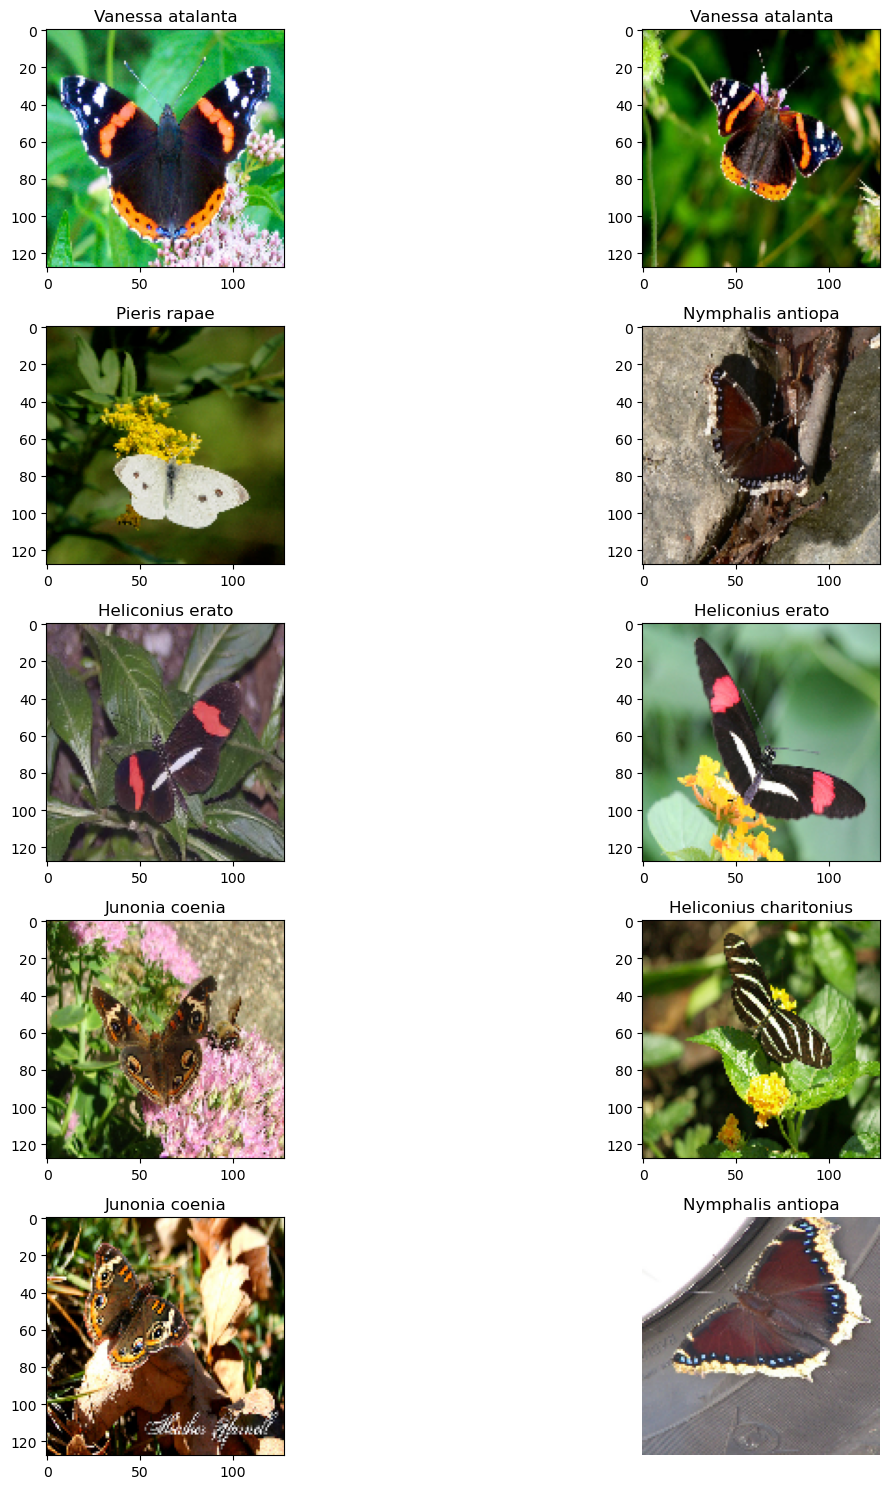

In [160]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(classes[labels[l]]))
plt.axis('off')
plt.tight_layout()
plt.show()

Display dataset distribution

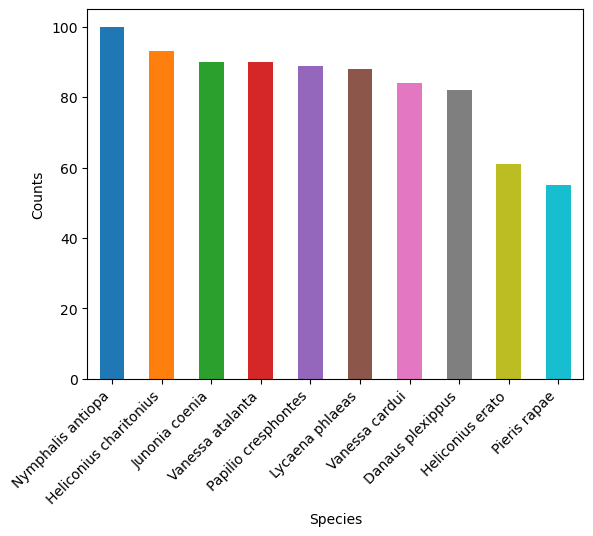

In [161]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = [classes[i] for i in df['labels']]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

In [162]:
data_min = np.min(data, axis=(0, 1, 2), keepdims=True)
data_max = np.max(data, axis=(0, 1, 2), keepdims=True)
data_scaled = (data - data_min) / (data_max - data_min)
mean = np.mean(data_scaled, axis=(0, 1, 2))
std = np.std(data_scaled, axis=(0, 1, 2))

In [163]:
print(mean)
print(std)

[0.46169255 0.44689858 0.32082972]
[0.28624429 0.26830092 0.27690185]


Data agumentation

In [164]:
class_counts = Counter(labels)
target_count = 100
samples_needed = {cls: target_count - count for cls, count in class_counts.items()}
aug_data, aug_labels = [], []

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

In [165]:
for img, label in zip(data, labels):
    if samples_needed[label] > 0: # all classes have more than target_count/2 samples so this method is safe
        img = Image.fromarray(img)
        img = transform(img)
        aug_data.append(img)
        aug_labels.append(label)
        samples_needed[label] -= 1
data = np.concatenate([data, aug_data], axis=0)
labels = np.concatenate([labels, aug_labels], axis=0)

In [166]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx])
        return data, labels

## Training pipeline

Split into training data and test data

In [167]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=transform)
trainset, testset = random_split(dataset, [0.8, 0.2])

Train and validate methods

In [168]:
def fit(net, trainloader, optimizer, loss_fn=nn.CrossEntropyLoss()):
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum().item()
        count += len(labels)
    return total_loss / count, acc / count

def predict(net, valloader, loss_fn=nn.CrossEntropyLoss()):
    net.eval()
    count, acc, total_loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in valloader:
            features = features.to(device)
            labels = labels.to(device)
            count += len(labels)
            out = net(features)
            total_loss += loss_fn(out, labels).item()
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum().item()
    return total_loss / count, acc / count

Objective method for k fold cross validation

In [169]:
def objective(trial, trainset, X, y):
    lr = trial.suggest_float('lr', 0.0009, 0.9, log=True)
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    val_accs = []
    train_acc, train_loss, val_acc, val_loss, mean_acc = 0, 0, 0, 0, 0
    split_num = 0
    prog_bar = tqdm(skf.split(X, y), desc="Splits")
    for train_index, val_index in prog_bar:
        split_num += 1
        train_data = Subset(trainset, train_index)
        val_data = Subset(trainset, val_index)
        trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
        valloader = DataLoader(val_data, batch_size=64, shuffle=False)

        for epoch in range(100):
            train_loss, train_acc = fit(net, trainloader, optimizer)
            val_loss, val_acc = predict(net, valloader)
            prog_bar.set_description(
                f"Split {split_num} - Epoch {epoch + 1}, Train acc={train_acc:.3f}, Train loss={train_loss:.3f}, "
                f"Validation acc={val_acc:.3f}, Validation loss={val_loss:.3f}")

        val_accs.append(val_acc)
        mean_acc = np.mean(val_accs)
        trial.report(mean_acc, split_num)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_acc

CNN definition

In [177]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 15, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(15, 30, 5)
        self.conv3 = nn.Conv2d(30, 50, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(50 * 18 * 18, 64) # ((100 -4)/2 -4)/2 -4
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = F.dropout(F.relu(self.fc1(x)), p=0.5)
        x = self.fc2(x)
        return x

In [171]:
X = np.zeros(len(trainset))
labelloader =  DataLoader(trainset, batch_size=256, shuffle=False)
y = []
for _, label in labelloader:
    y.append(label.numpy())
y = np.concatenate(y, axis=0)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, X, y), n_trials=10)

[I 2024-09-14 20:05:32,176] A new study created in memory with name: no-name-f98e0805-ea27-4320-969b-a49fef83f8b5


Splits: 0it [00:00, ?it/s]

[W 2024-09-14 20:05:35,800] Trial 0 failed with parameters: {'lr': 0.1202458732812222} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4262/2730426715.py", line 8, in <lambda>
    study.optimize(lambda trial: objective(trial, trainset, X, y), n_trials=10)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4262/3064081381.py", line 19, in objective
    train_loss, train_acc = fit(net, trainloader, optimizer)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4262/2886258072.py", line 4, in fit
    for features, labels in trainloader:
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data =

KeyboardInterrupt: 

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

start tensorboard to further visualization of the CNN

In [178]:
writer = SummaryWriter("../runs")
net = Net().to(device)
writer.add_graph(net, torch.zeros((1, 3, pixels_per_side, pixels_per_side)).to(device))
writer.flush()
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%input : Float(1, 128, strides=[128, 1], requires_grad=1, device=cuda:0) = aten::dropout(%input.21, %128, %129) # /home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/nn/functional.py:1295:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 10 / 10 (100.0%)
Greatest absolute difference: 0.010613787919282913 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.4544953114831221 at index (0, 5) (up to 1e-05 allowed)
  _check_trac

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 124, 124]         1,216
├─MaxPool2d: 1-2                         [1, 16, 62, 62]           --
├─Conv2d: 1-3                            [1, 32, 52, 52]           61,984
├─Conv2d: 1-4                            [1, 64, 50, 50]           18,496
├─MaxPool2d: 1-5                         [1, 64, 25, 25]           --
├─Flatten: 1-6                           [1, 40000]                --
├─Linear: 1-7                            [1, 128]                  5,120,128
├─Linear: 1-8                            [1, 10]                   1,290
Total params: 5,203,114
Trainable params: 5,203,114
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 237.66
Input size (MB): 0.20
Forward/backward pass size (MB): 3.94
Params size (MB): 20.81
Estimated Total Size (MB): 24.95

In [179]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
optimizer = optim.Adam(net.parameters(), lr=0.00101)# lr=trial.params['lr'])
train_accs, train_losses, test_accs, test_losses = [], [], [], []
prog_bar = tqdm(range(100), total=100)
for epoch in prog_bar:
    train_loss, train_acc = fit(net,trainloader, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_loss, test_acc = predict(net, testloader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    prog_bar.set_description(f"Epoch {epoch + 1}, Train acc={train_acc:.3f}, Train loss={train_loss:.3f}, "
                             f"Test acc={test_acc:.3f}, Test loss={test_loss:.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

## Evaulate results

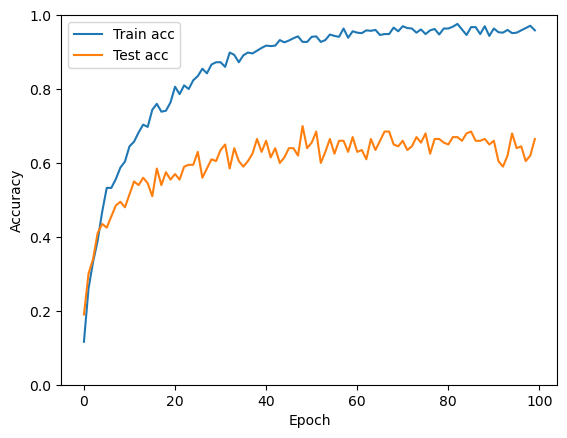

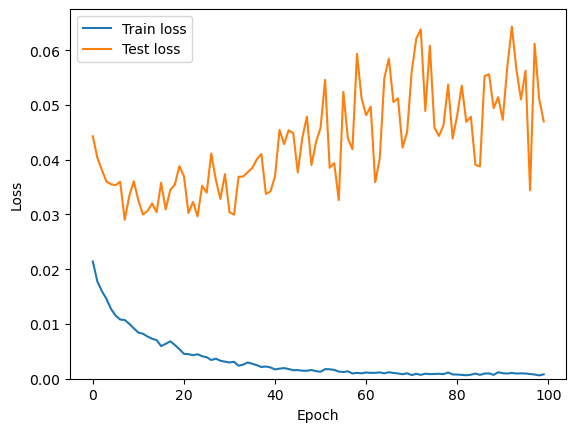

In [180]:
plt.figure()
plt.plot(train_accs, label='Train acc')
plt.plot(test_accs, label='Test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()